In [1]:
import xarray as xr
import metpy.calc as mpcalc
from metpy import units
import cartopy.crs as ccrs, cartopy.feature as cf
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime as dt
import pandas as pd
from netCDF4 import Dataset
from wrf import to_np

In [2]:
ds = xr.open_dataset('500_instability_interpolated.nc')

In [3]:
ds = ds.isel(Time=slice(20,57))
ds

<xarray.Dataset>
Dimensions:             (south_north: 285, west_east: 393, Time: 37,
                         mcape_mcin_lcl_lfc: 4)
Coordinates:
    XLONG               (south_north, west_east) float32 ...
    XLAT                (south_north, west_east) float32 ...
    XTIME               (Time) float64 ...
  * Time                (Time) datetime64[ns] 2018-12-13T15:00:00 ... 2018-12-14
  * mcape_mcin_lcl_lfc  (mcape_mcin_lcl_lfc) object 'mcape' 'mcin' 'lcl' 'lfc'
Dimensions without coordinates: south_north, west_east
Data variables:
    cape_2d             (mcape_mcin_lcl_lfc, Time, south_north, west_east) float32 ...

In [4]:
# remember to edit
startYear = 2018
startMonth = 12
startDay = 13
startHour = 15
startMinute = 0
startDateTime = dt(startYear,startMonth,startDay, startHour, startMinute)

endYear = 2018
endMonth = 12
endDay = 14
endHour = 0
endMinute = 0
endDateTime = dt(endYear,endMonth,endDay, endHour, endMinute)

In [5]:
dateList = pd.date_range(startDateTime, endDateTime, freq='.25H')
dateList

DatetimeIndex(['2018-12-13 15:00:00', '2018-12-13 15:15:00',
               '2018-12-13 15:30:00', '2018-12-13 15:45:00',
               '2018-12-13 16:00:00', '2018-12-13 16:15:00',
               '2018-12-13 16:30:00', '2018-12-13 16:45:00',
               '2018-12-13 17:00:00', '2018-12-13 17:15:00',
               '2018-12-13 17:30:00', '2018-12-13 17:45:00',
               '2018-12-13 18:00:00', '2018-12-13 18:15:00',
               '2018-12-13 18:30:00', '2018-12-13 18:45:00',
               '2018-12-13 19:00:00', '2018-12-13 19:15:00',
               '2018-12-13 19:30:00', '2018-12-13 19:45:00',
               '2018-12-13 20:00:00', '2018-12-13 20:15:00',
               '2018-12-13 20:30:00', '2018-12-13 20:45:00',
               '2018-12-13 21:00:00', '2018-12-13 21:15:00',
               '2018-12-13 21:30:00', '2018-12-13 21:45:00',
               '2018-12-13 22:00:00', '2018-12-13 22:15:00',
               '2018-12-13 22:30:00', '2018-12-13 22:45:00',
               '2018-12-

In [6]:
cape = ds.isel(mcape_mcin_lcl_lfc=0)

In [7]:
cape = cape['cape_2d']

In [8]:
cape

<xarray.DataArray 'cape_2d' (Time: 37, south_north: 285, west_east: 393)>
[4144185 values with dtype=float32]
Coordinates:
    XLONG               (south_north, west_east) float32 ...
    XLAT                (south_north, west_east) float32 ...
    XTIME               (Time) float64 300.0 315.0 330.0 ... 810.0 825.0 840.0
  * Time                (Time) datetime64[ns] 2018-12-13T15:00:00 ... 2018-12-14
    mcape_mcin_lcl_lfc  <U5 'mcape'
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY
    description:  mcape ; mcin ; lcl ; lfc
    units:        J kg-1 ; J kg-1 ; m ; m
    stagger:

In [9]:
lon, lat, time = ds.XLONG, ds.XLAT, ds.XTIME

In [10]:
lonW = -97.5
lonE = -25
latS = -60
latN = 0
cLat, cLon = (latS + latN)/2, (lonW + lonE)/2
proj_map = ccrs.Robinson(central_longitude=cLon)
proj_data = ccrs.PlateCarree()
res = '10m'

In [11]:
cape.max()

<xarray.DataArray 'cape_2d' ()>
array(5849.32568359)
Coordinates:
    mcape_mcin_lcl_lfc  <U5 'mcape'

In [12]:
capeLevs = np.arange(1000,5000,500)

In [14]:
from netCDF4 import Dataset
from wrf import getvar
wrf_file = Dataset('500_wrfout_files/wrfout_d02_2018-12-14_01:15:00')
ter = getvar(wrf_file, "ter", timeidx=-1)

/tmp/ipykernel_2589600/2854091047.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(18,12))


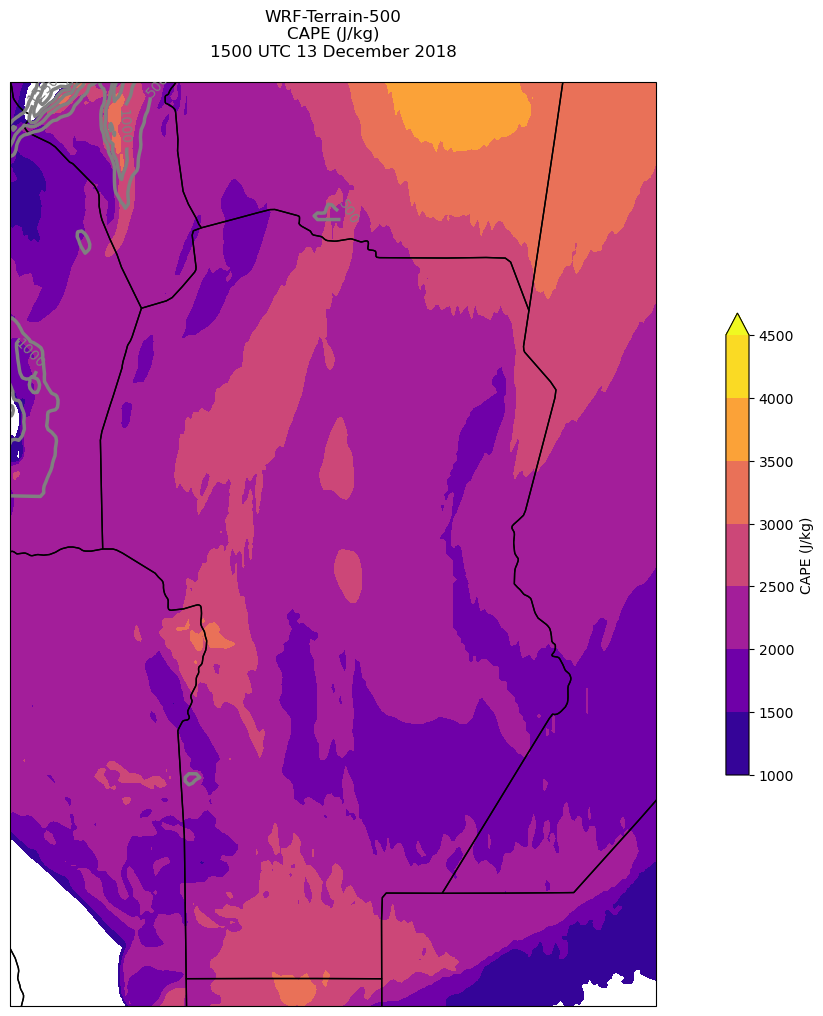

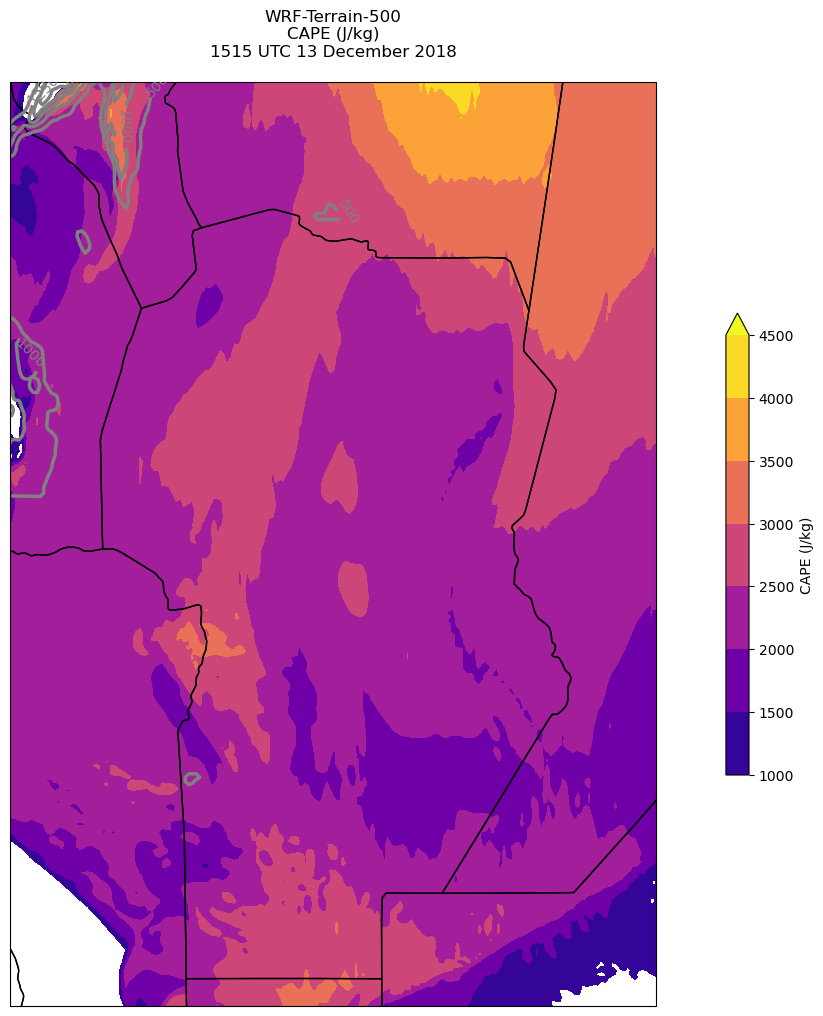

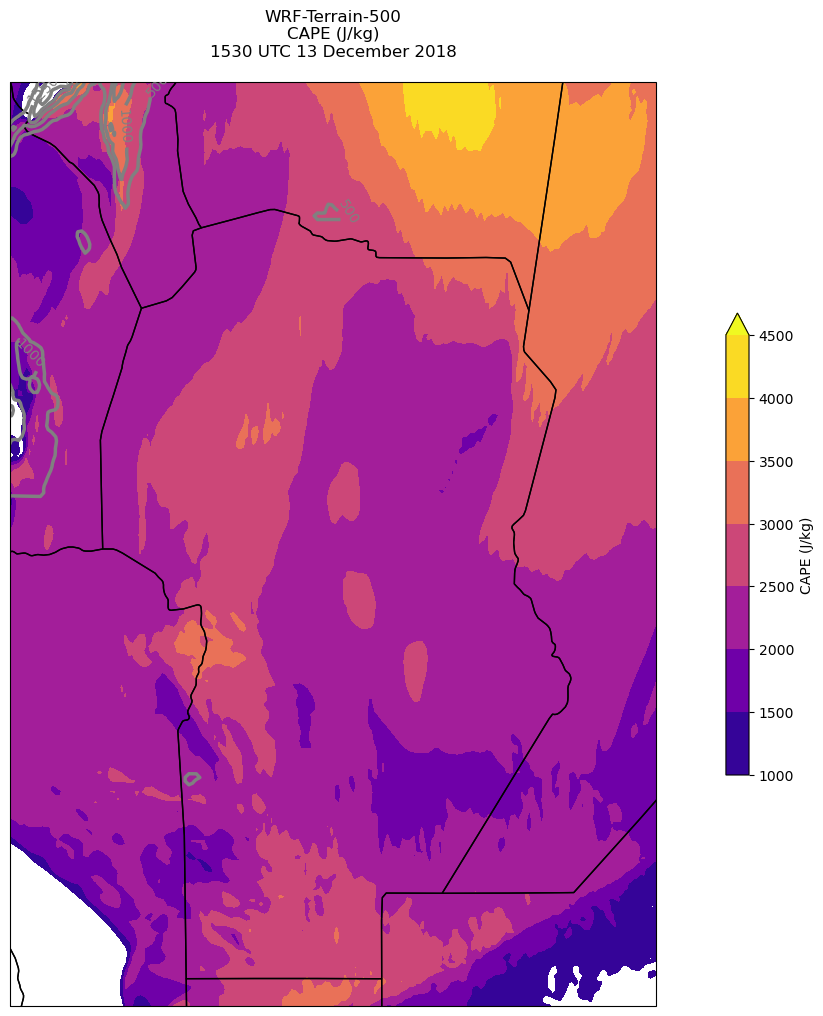

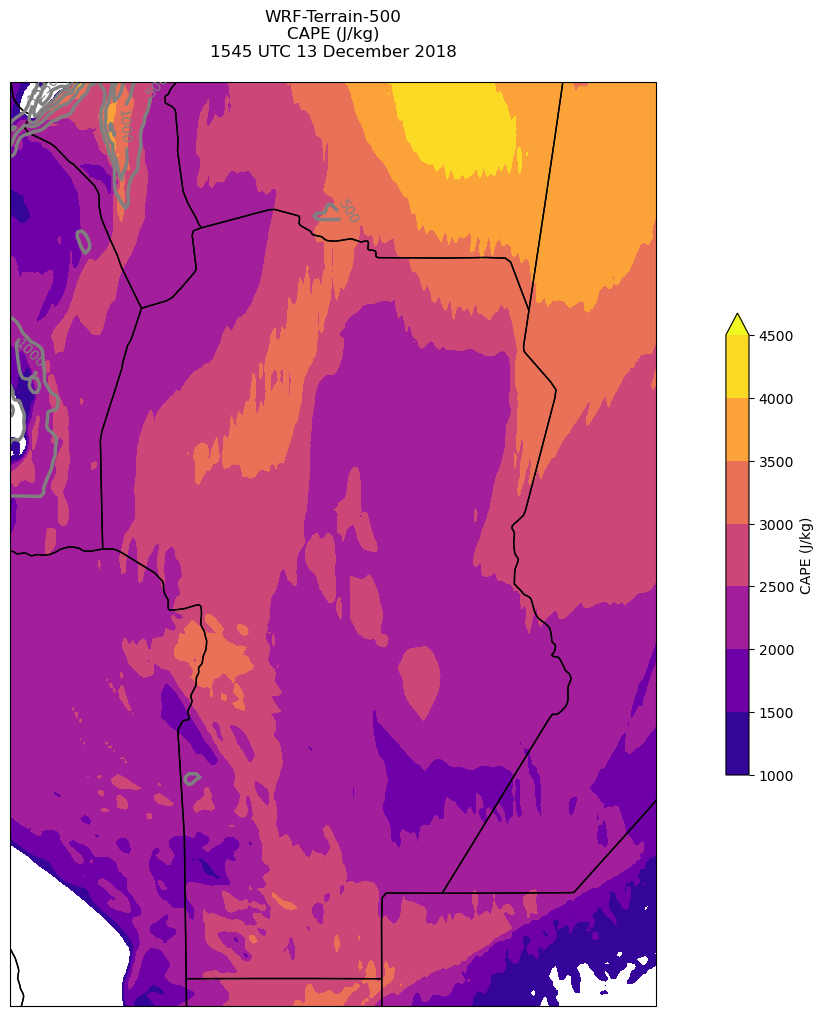

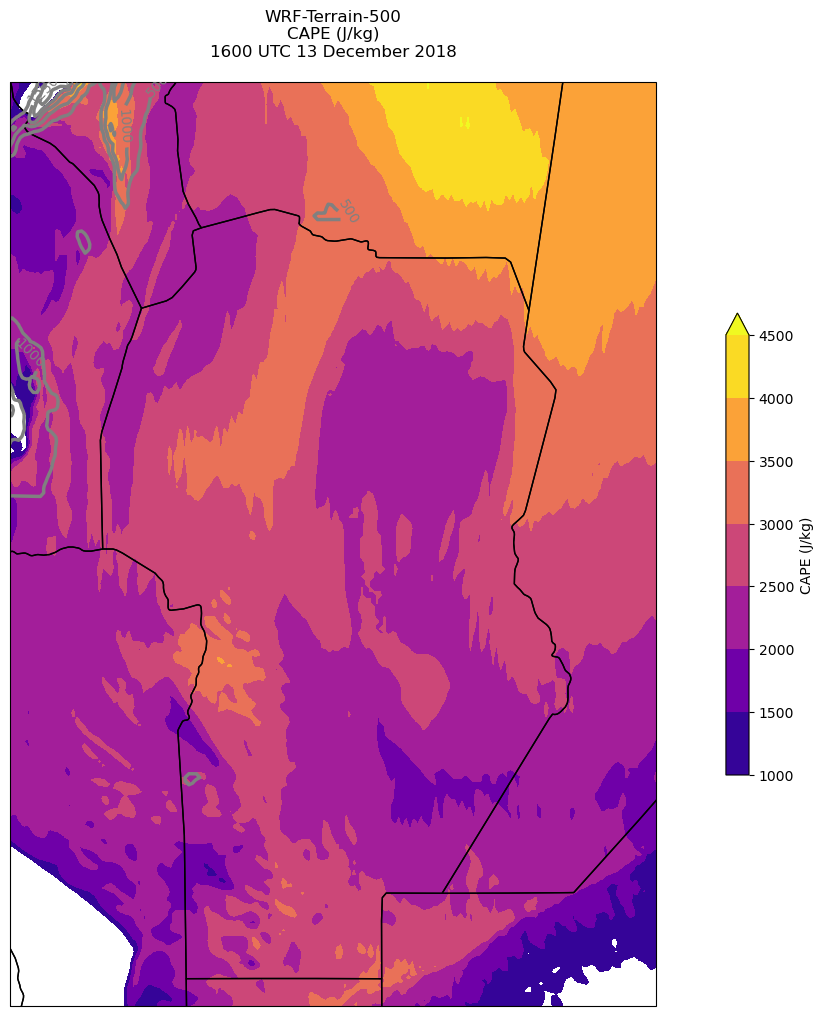

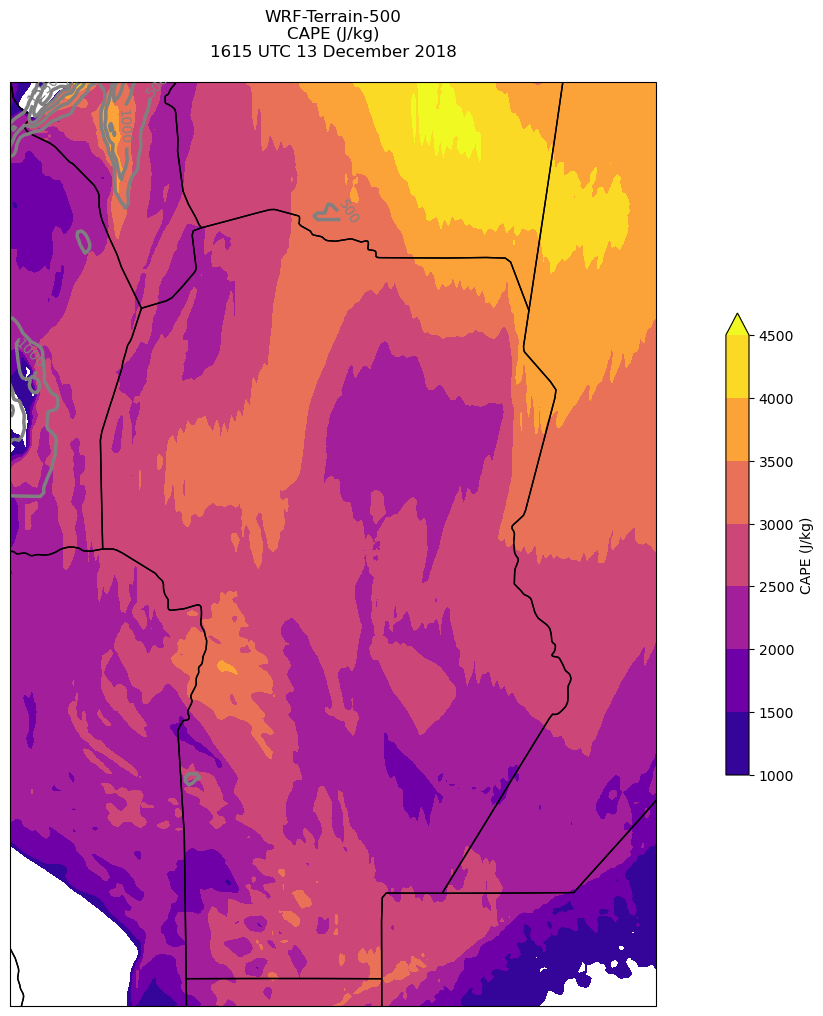

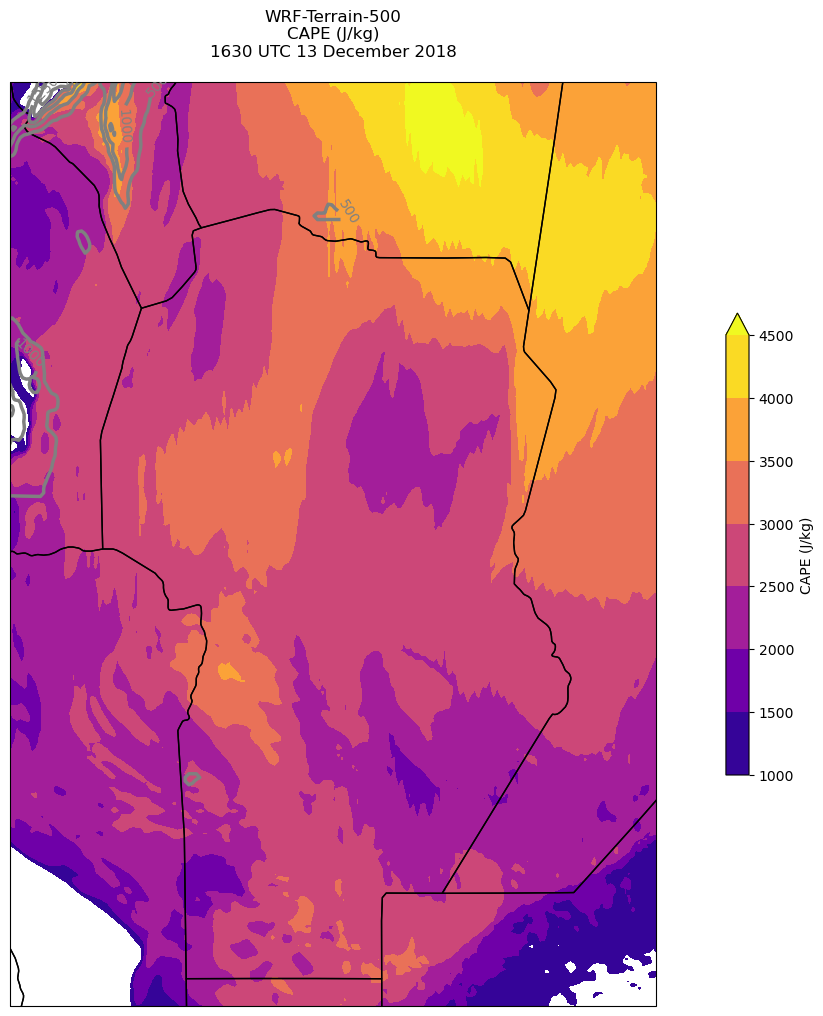

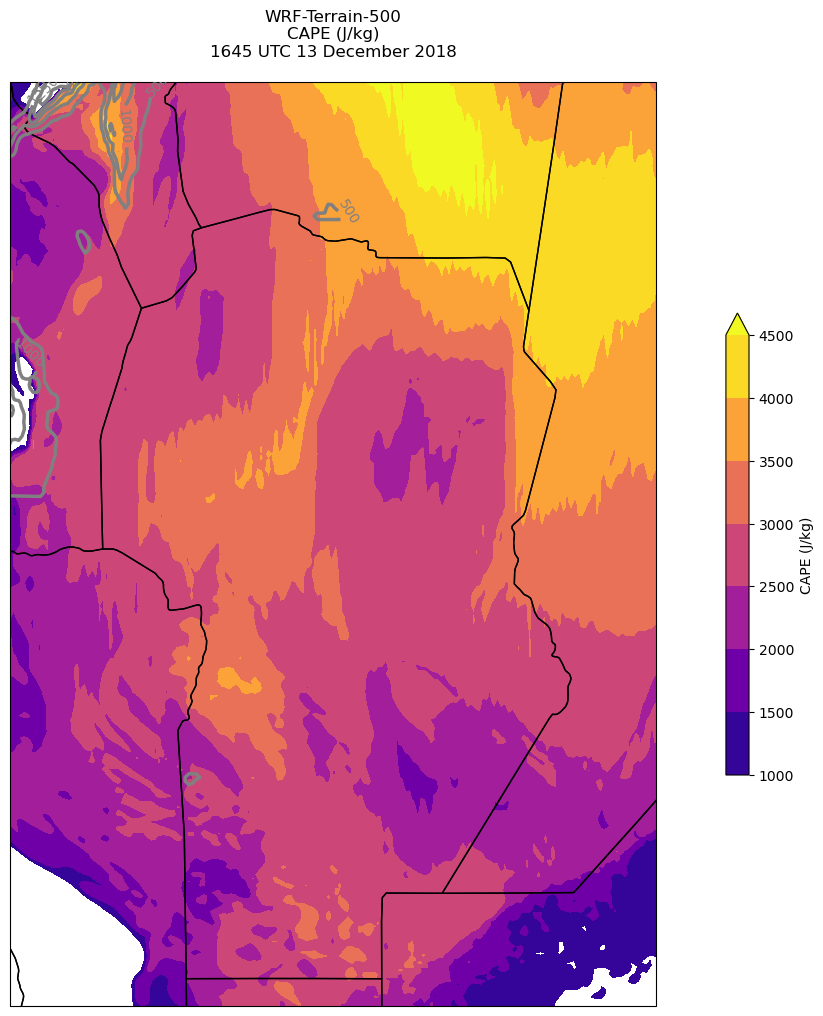

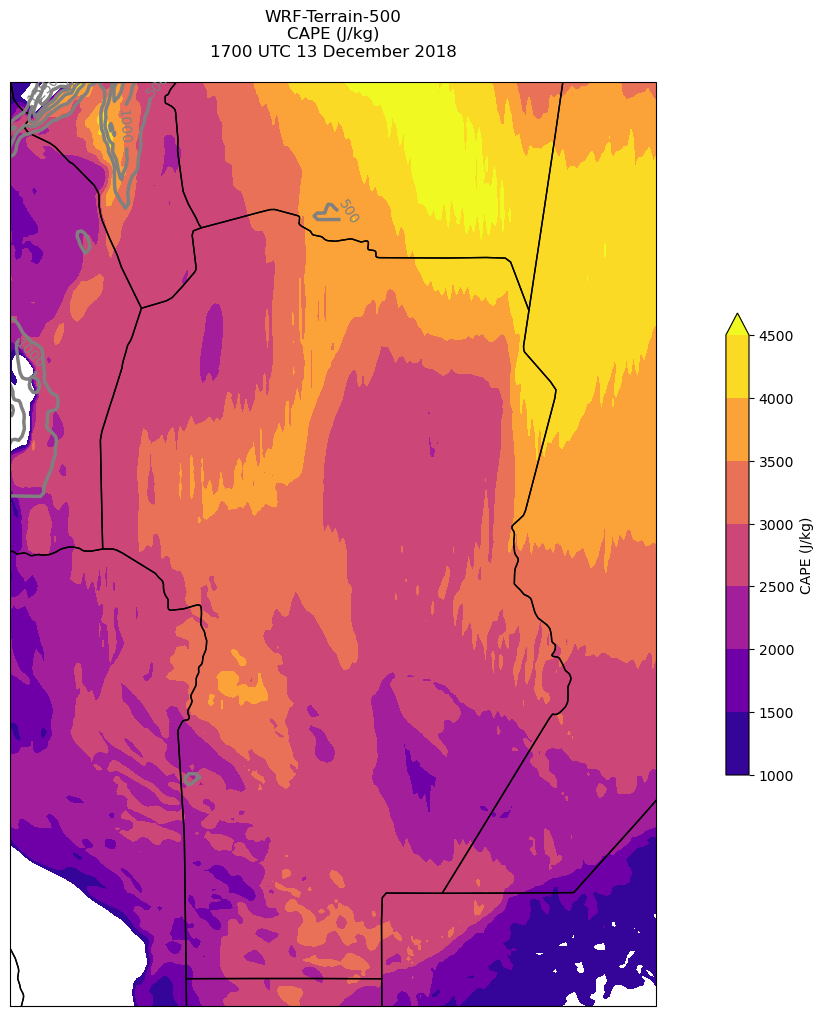

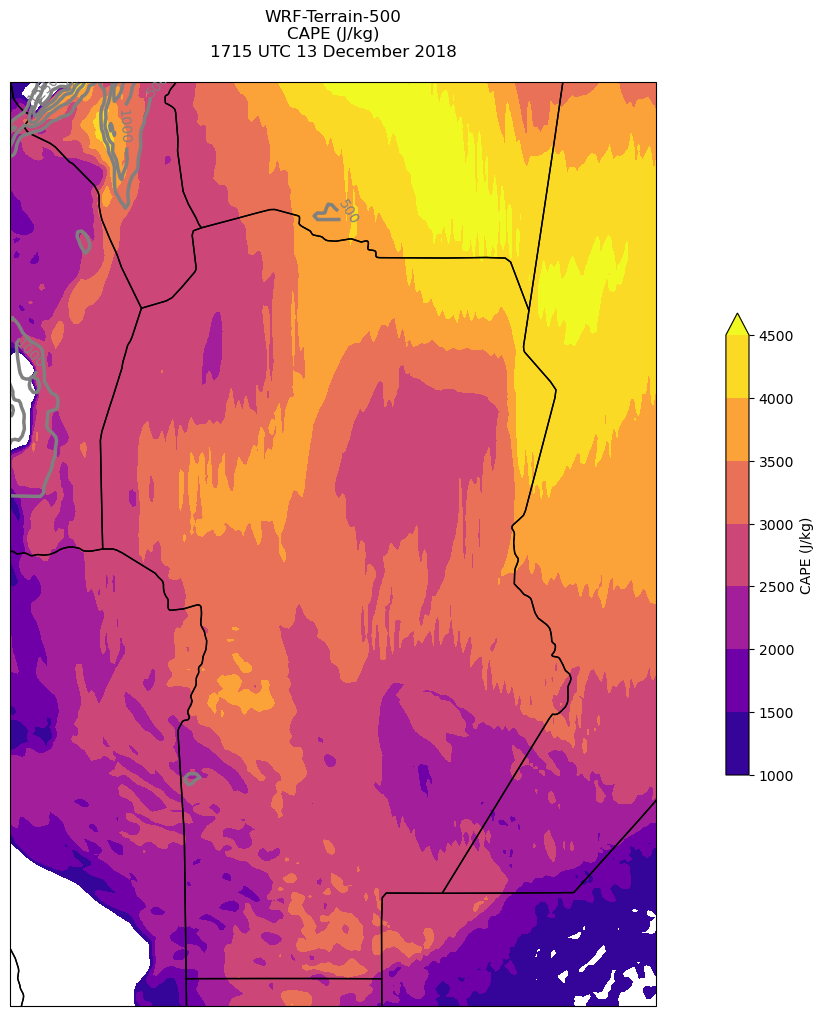

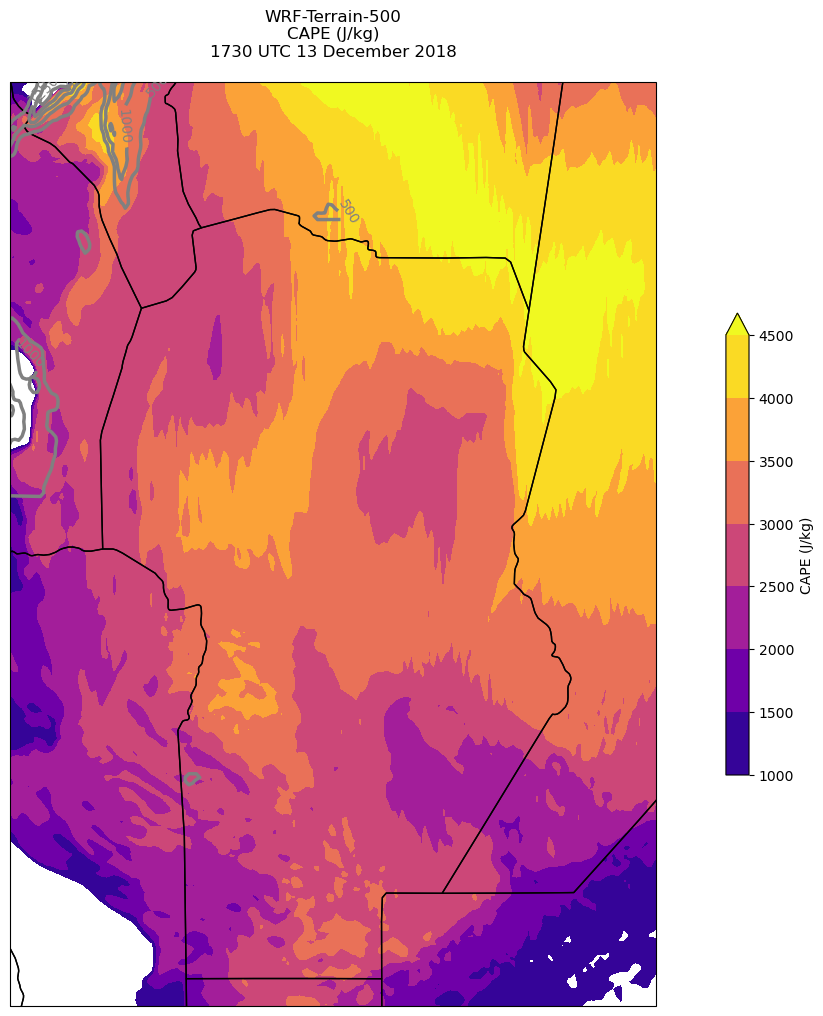

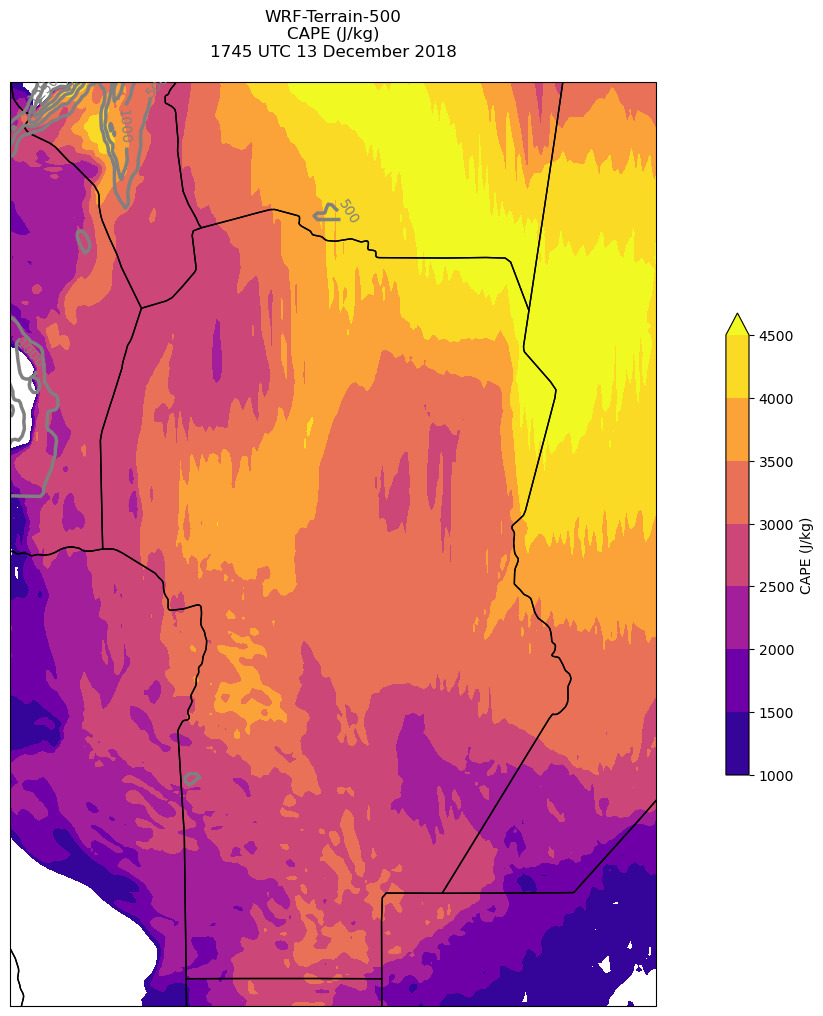

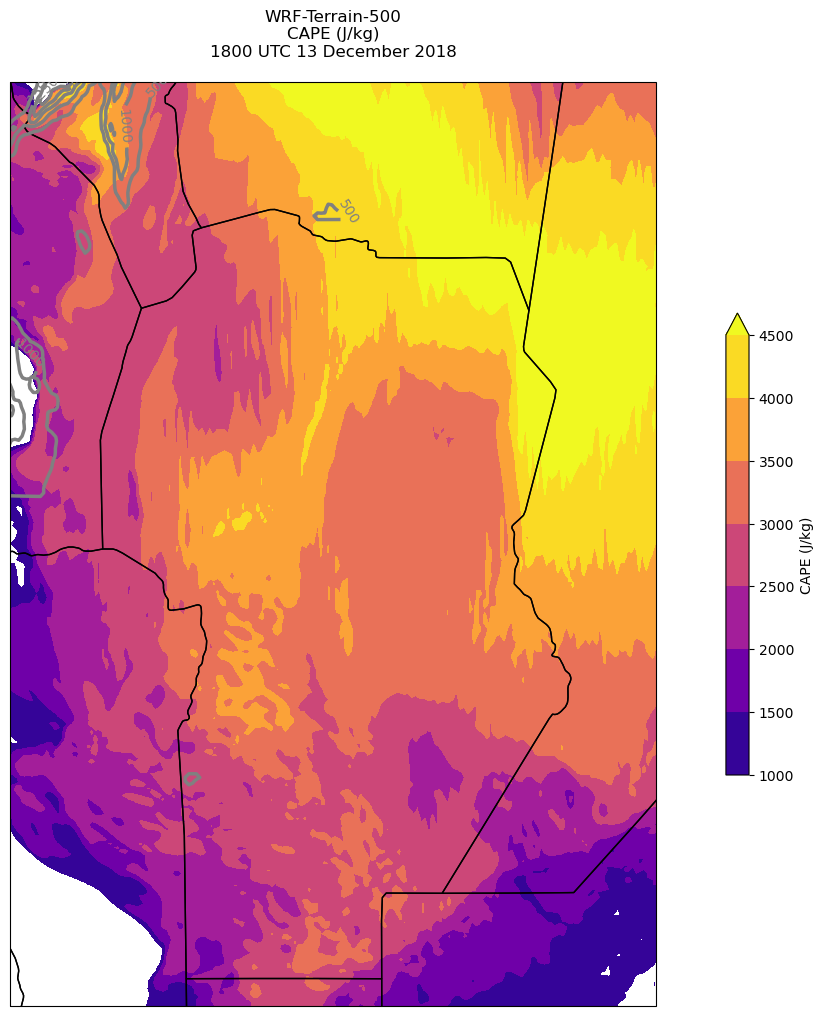

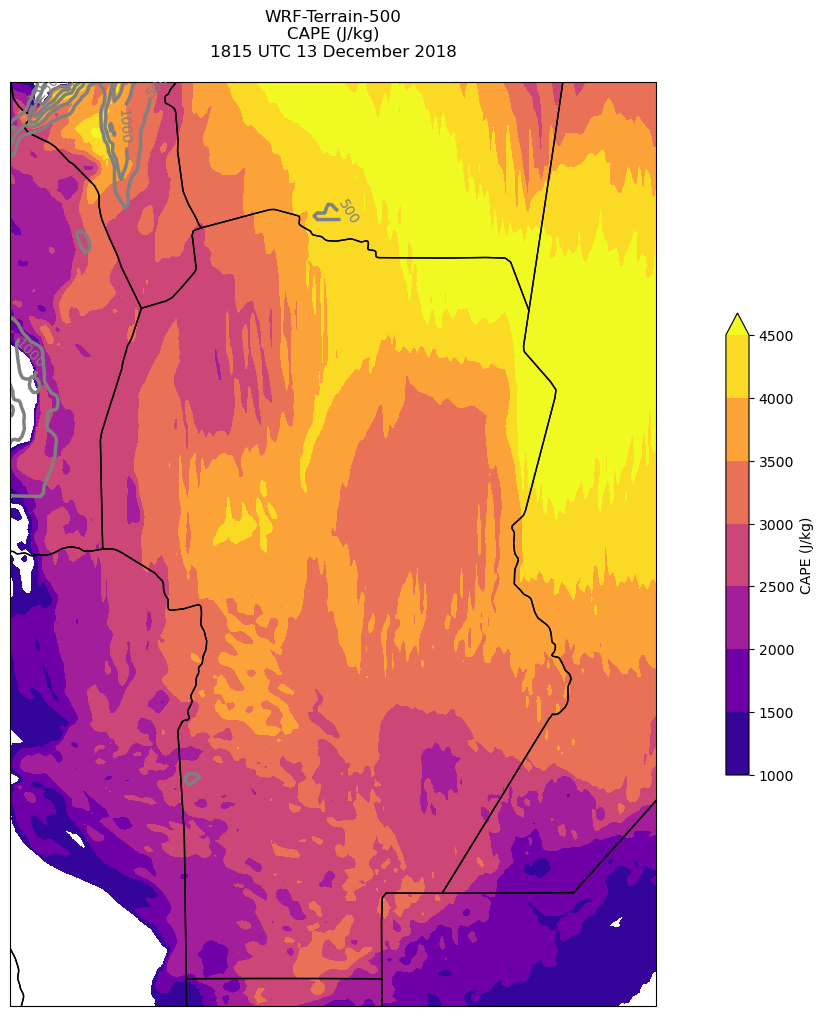

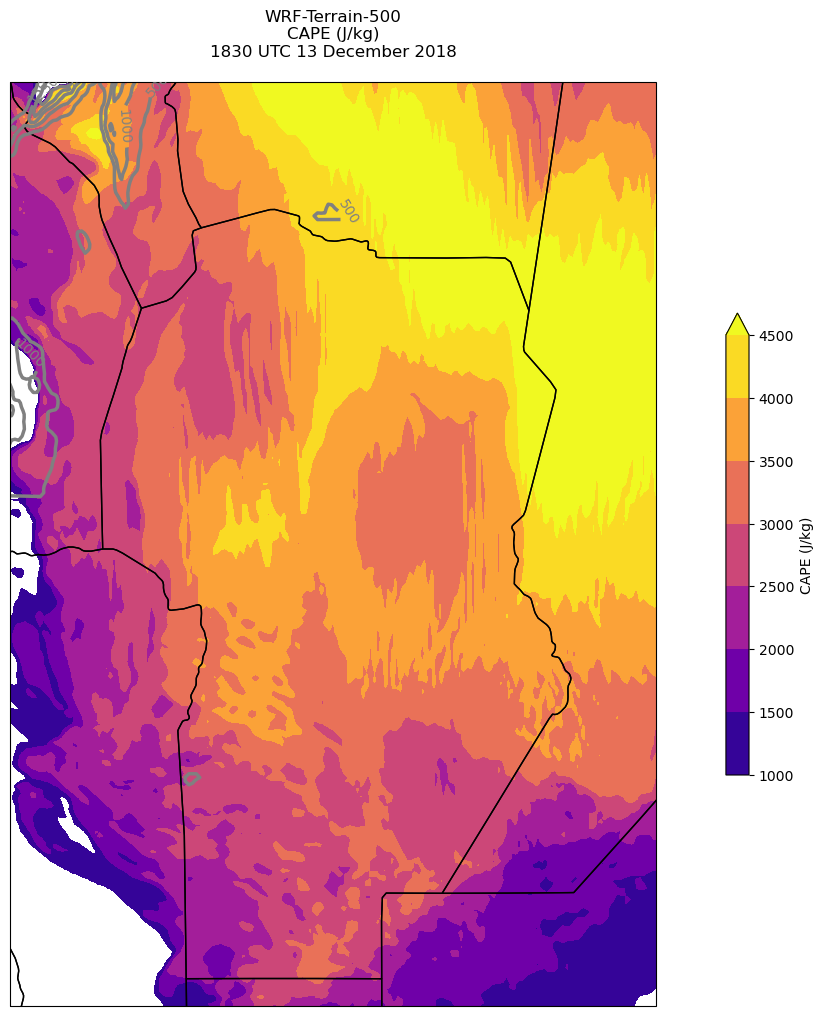

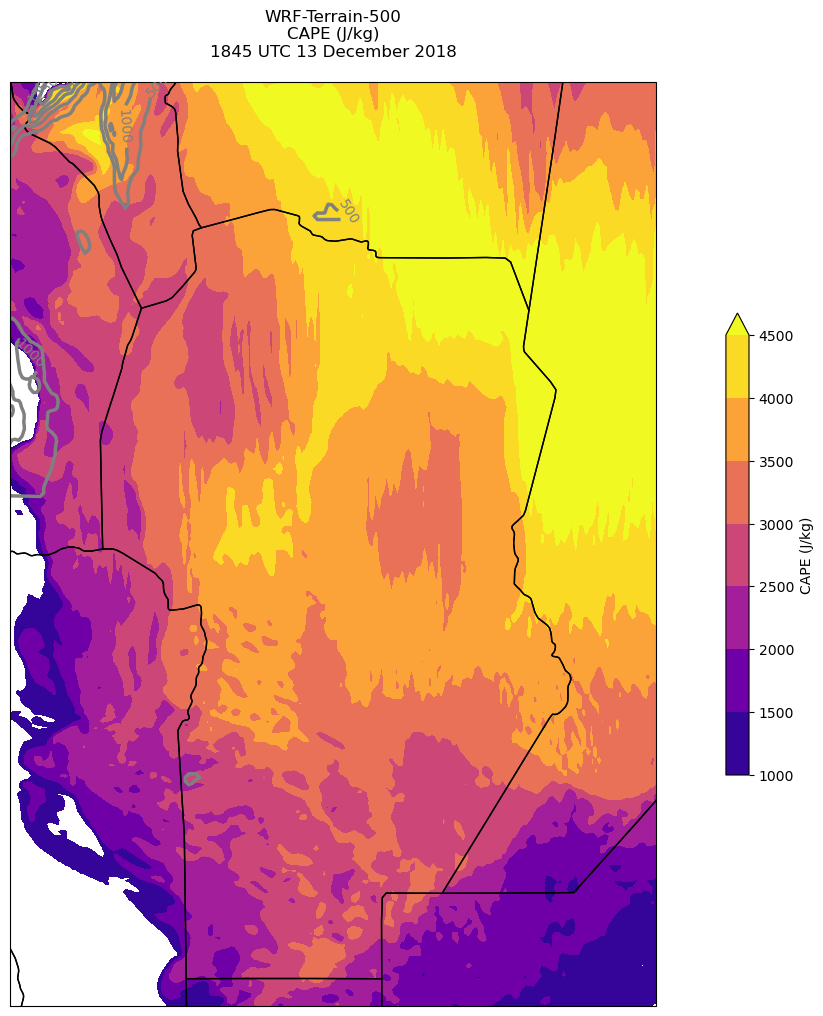

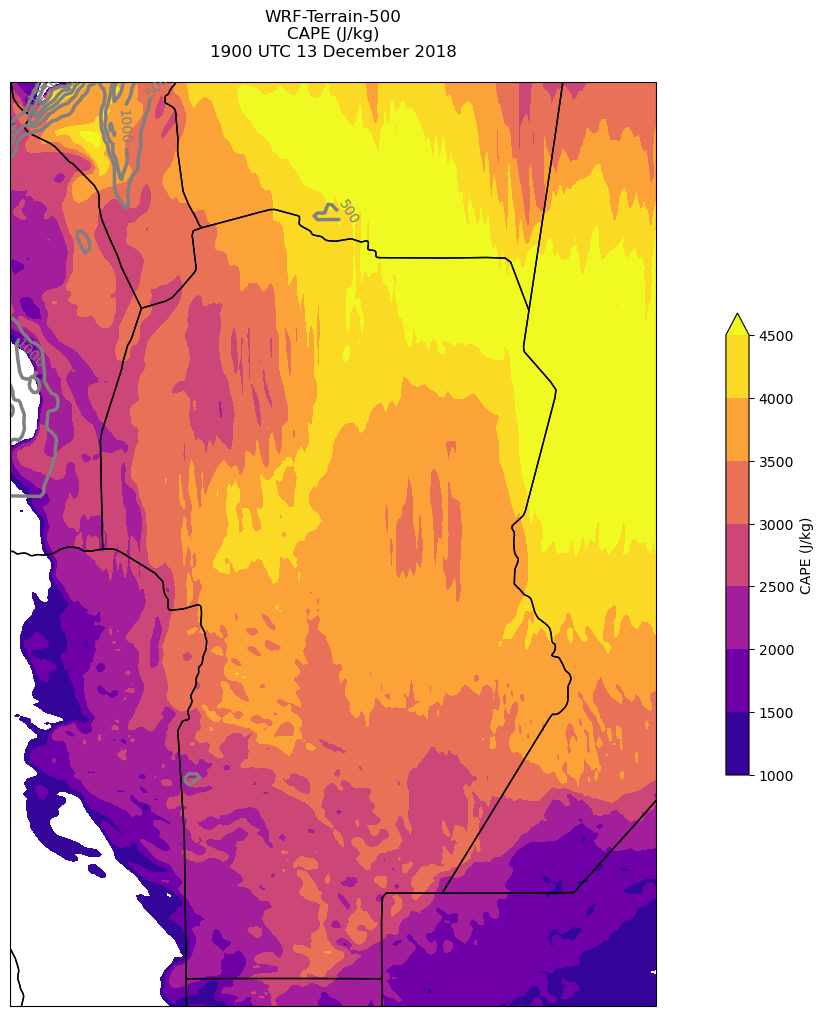

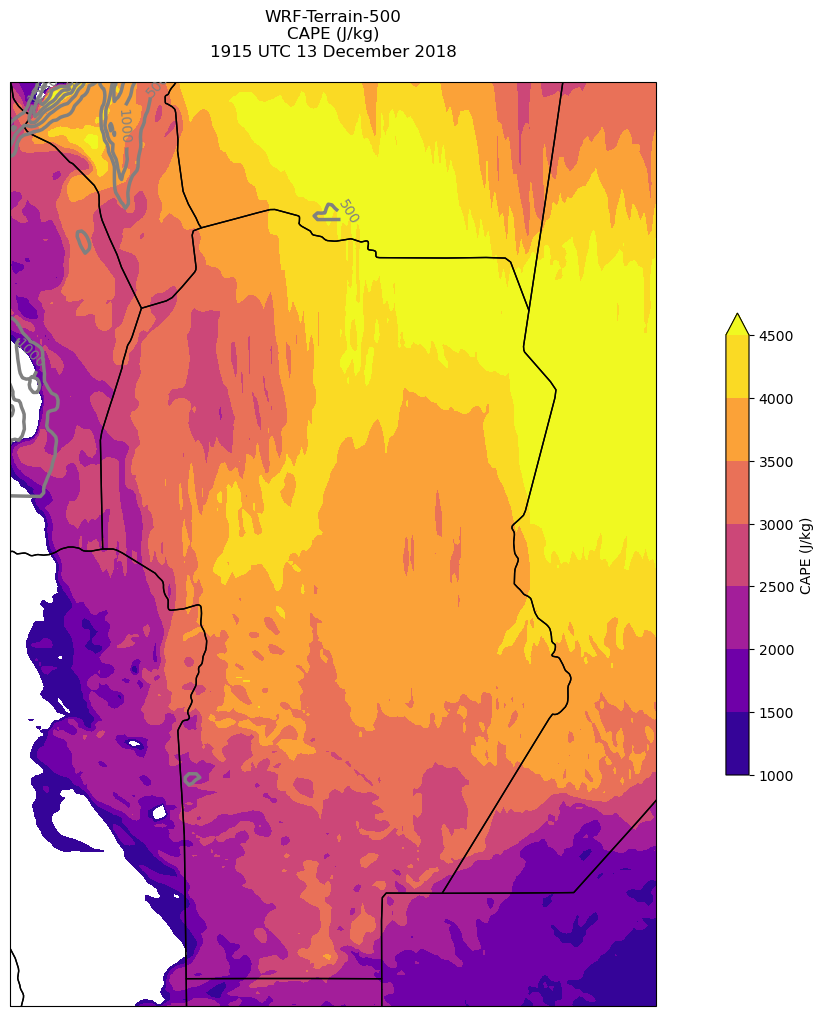

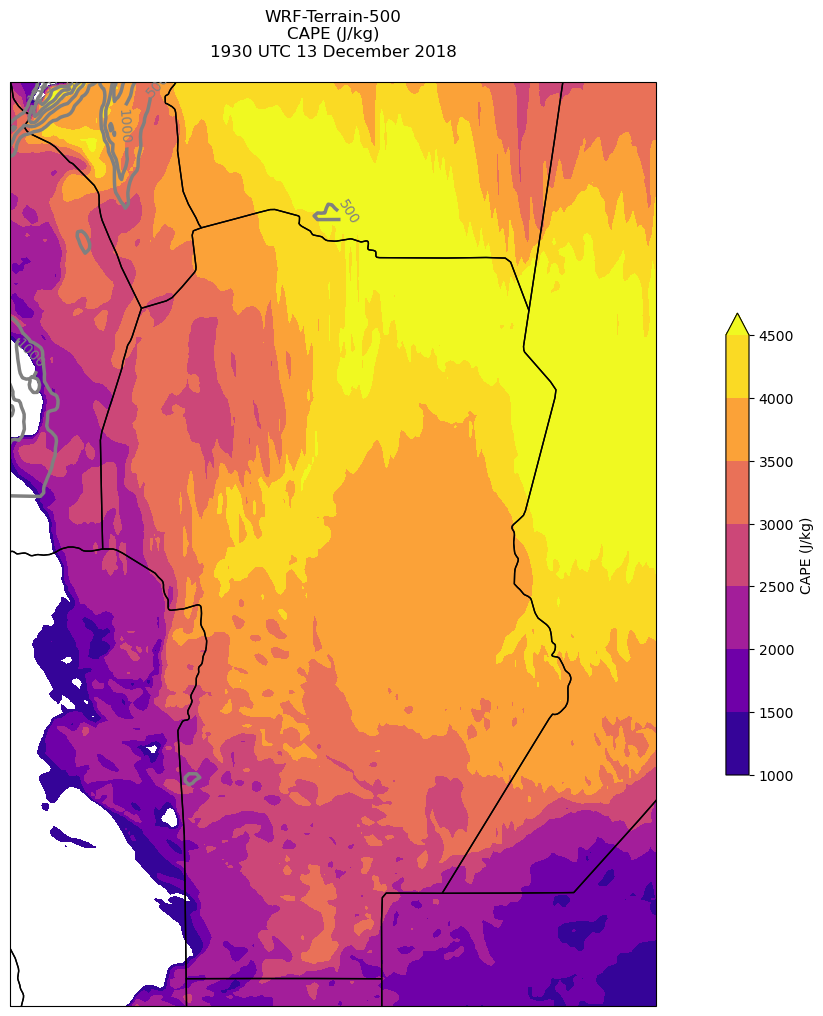

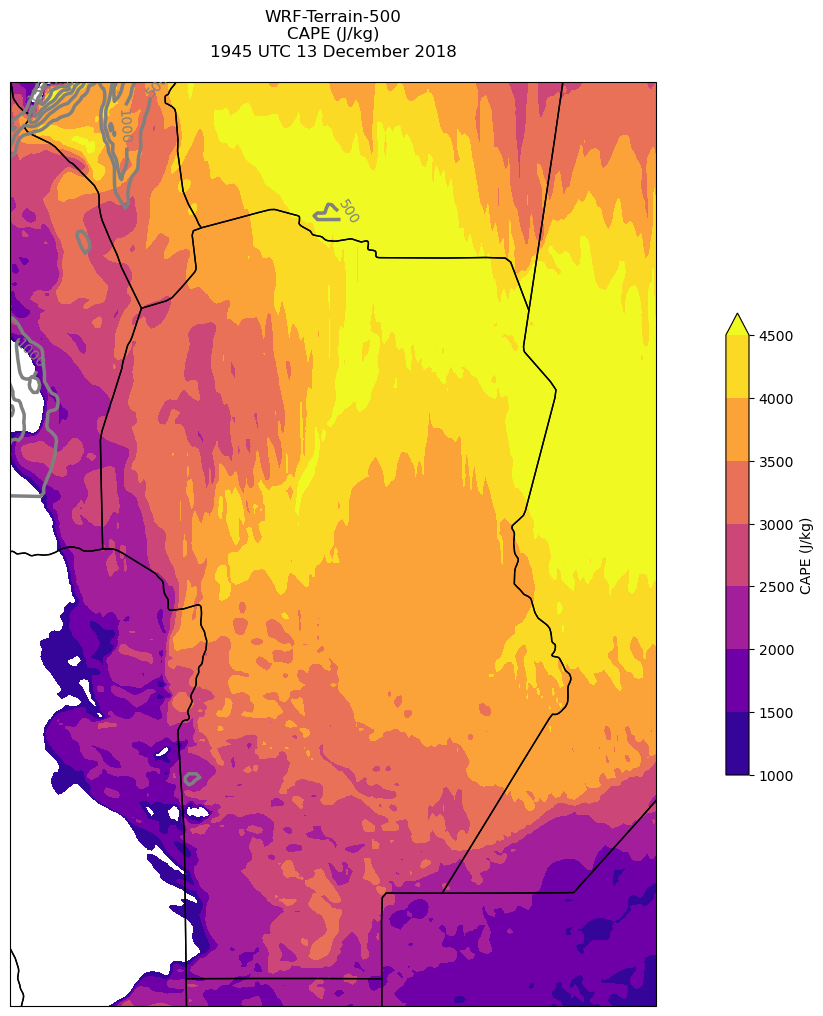

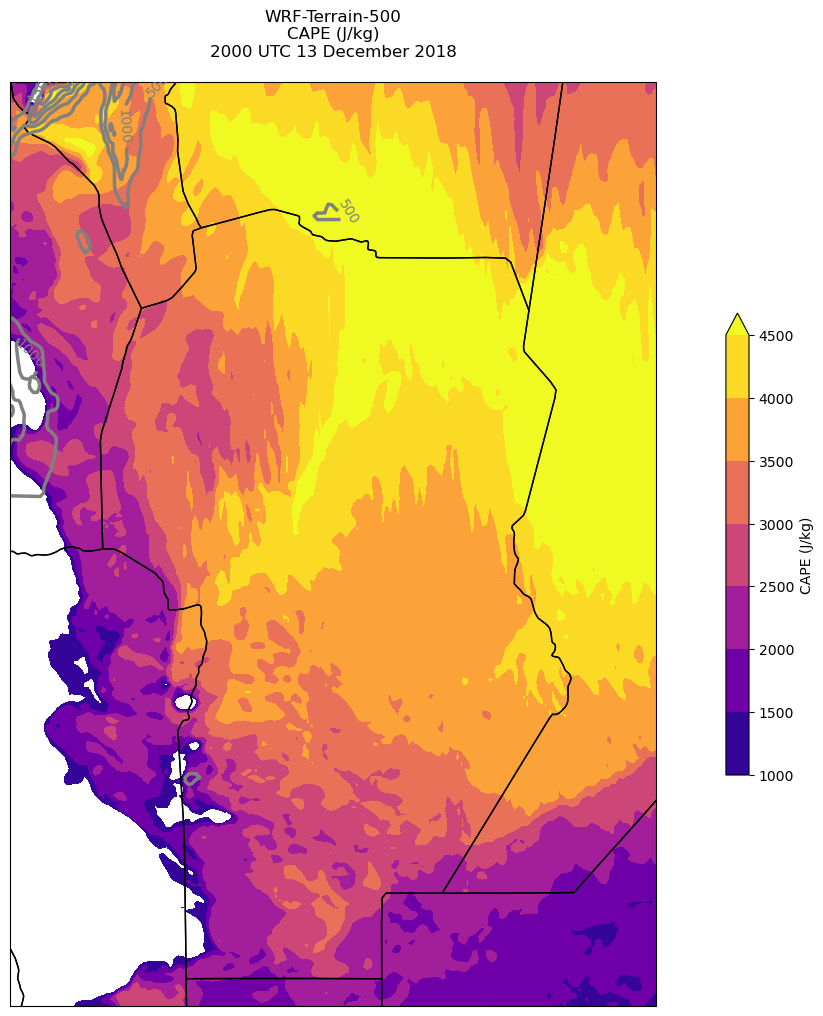

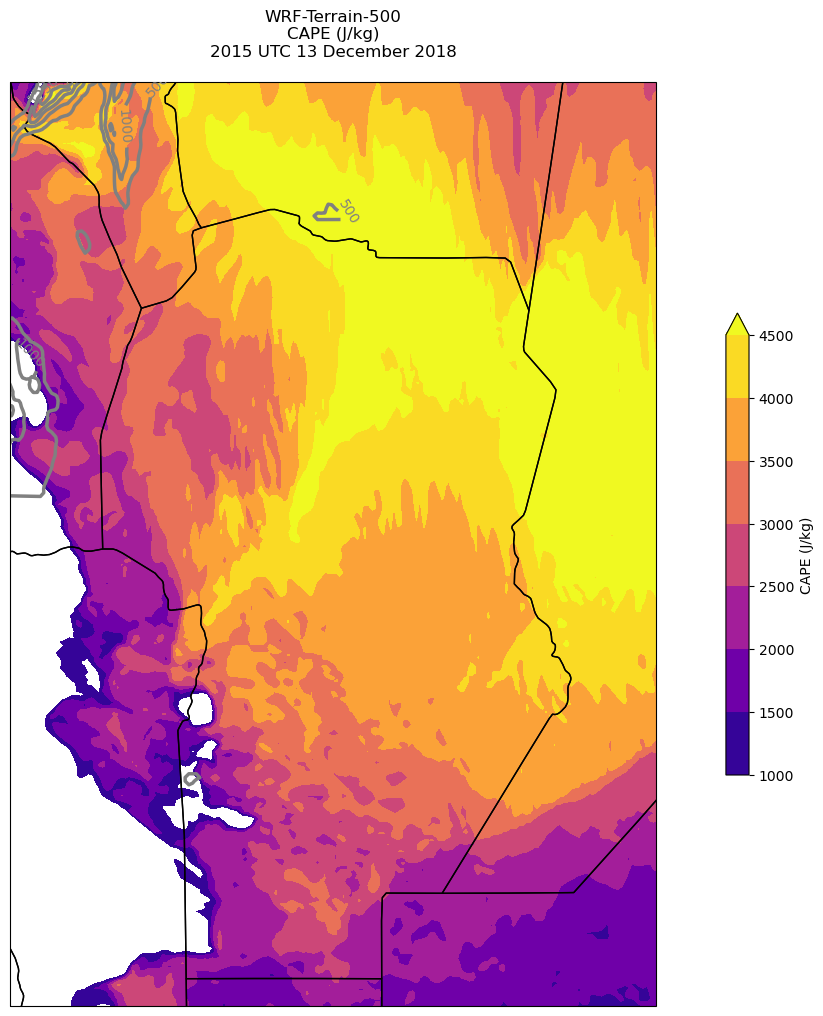

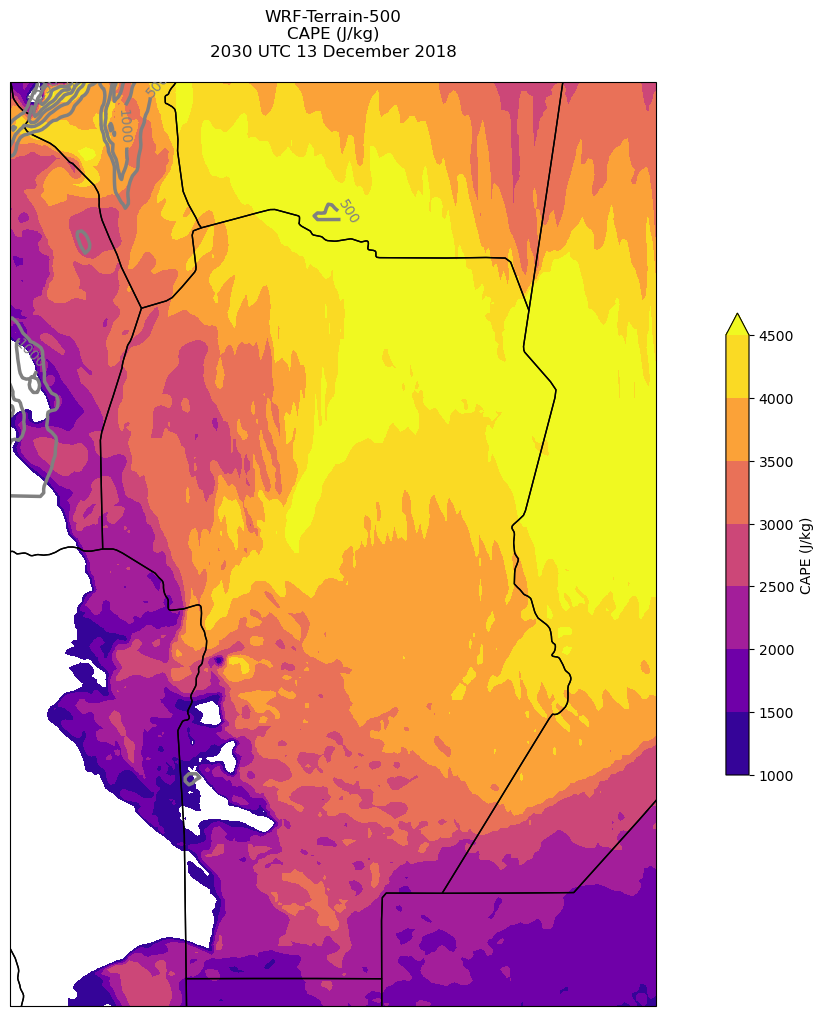

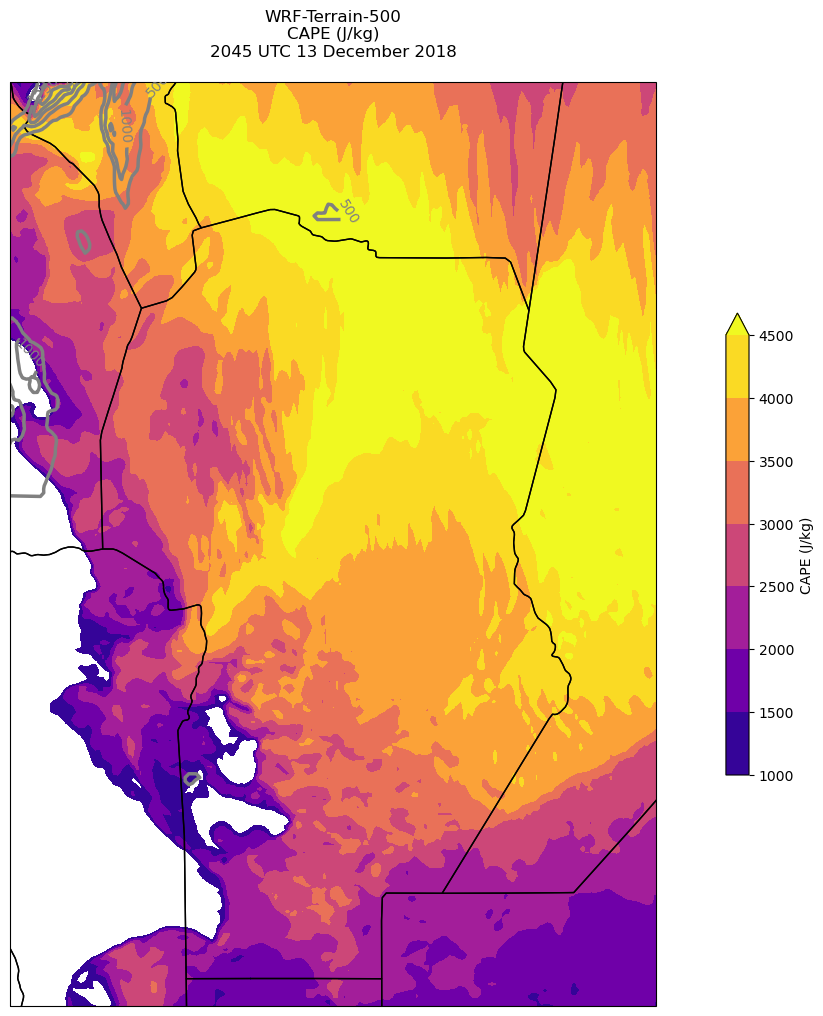

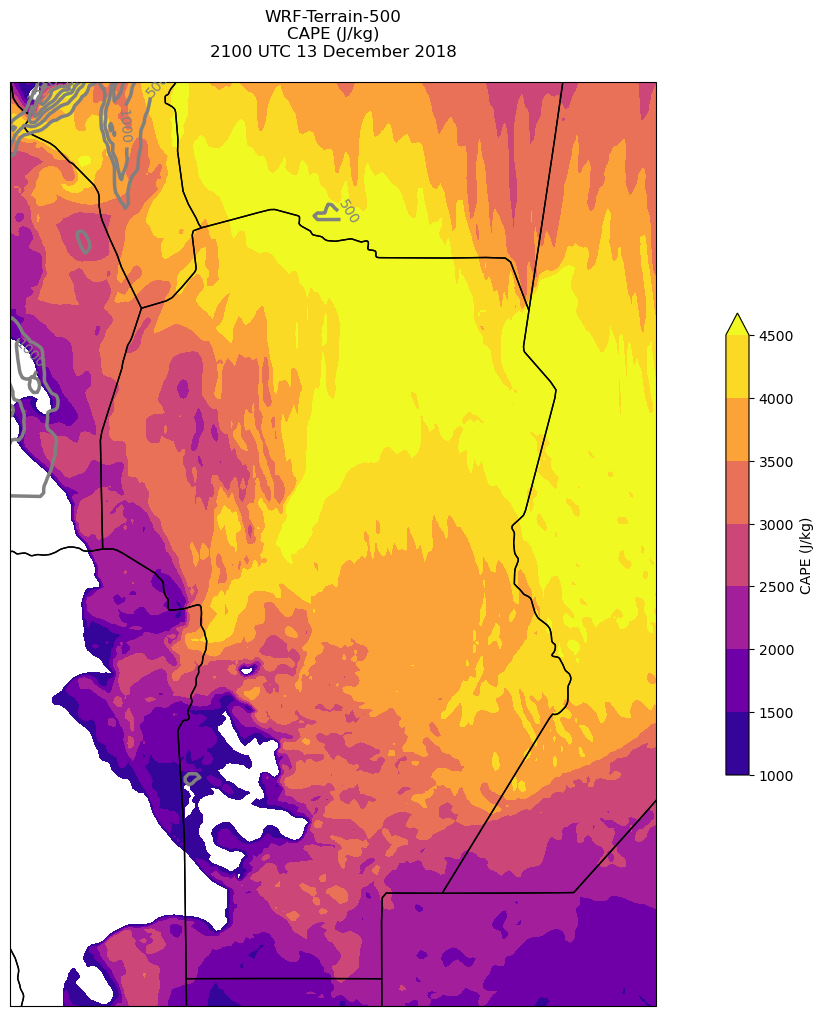

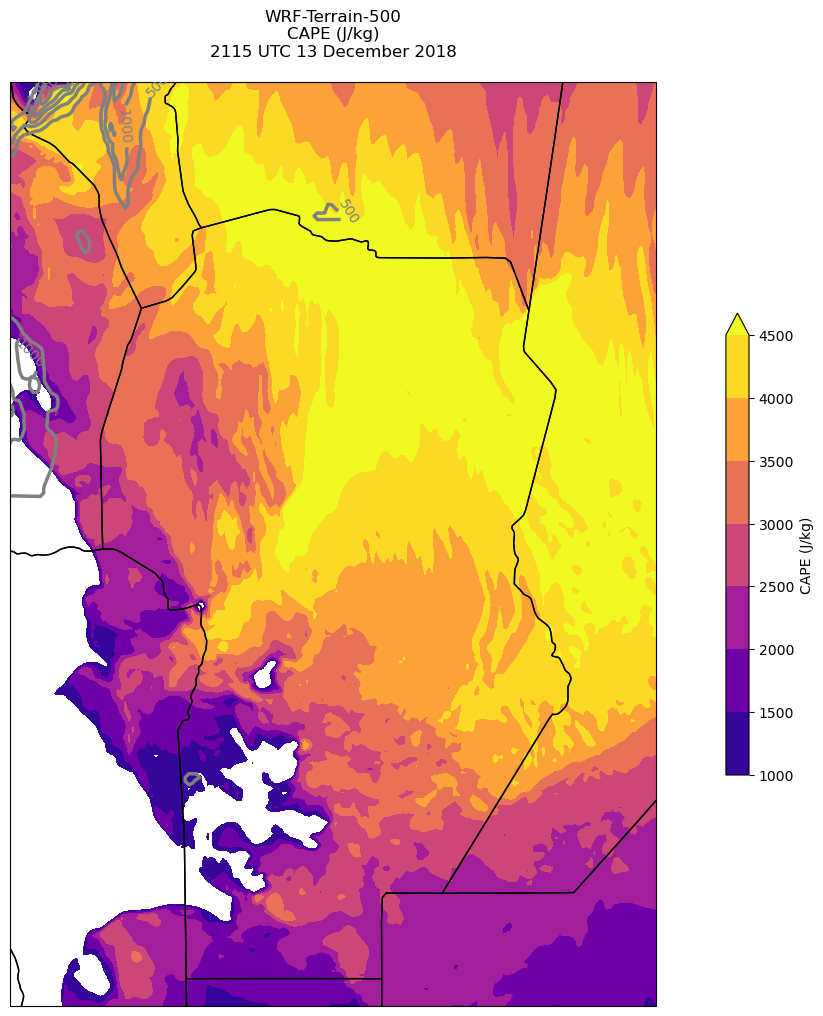

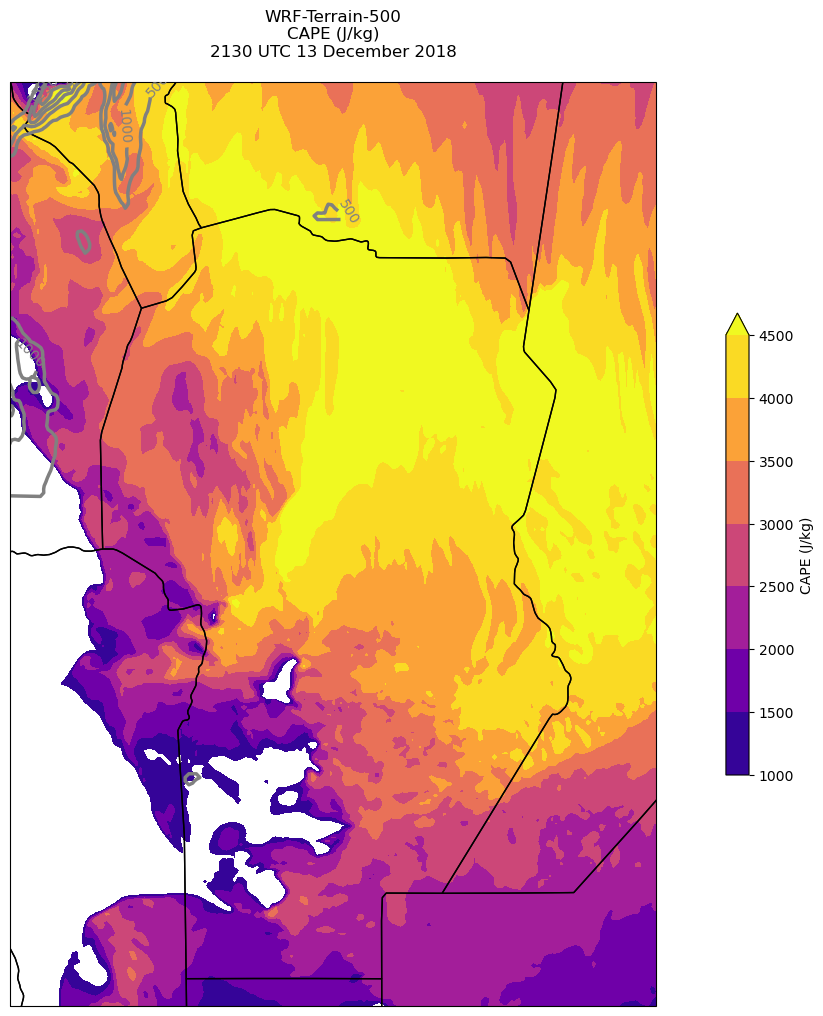

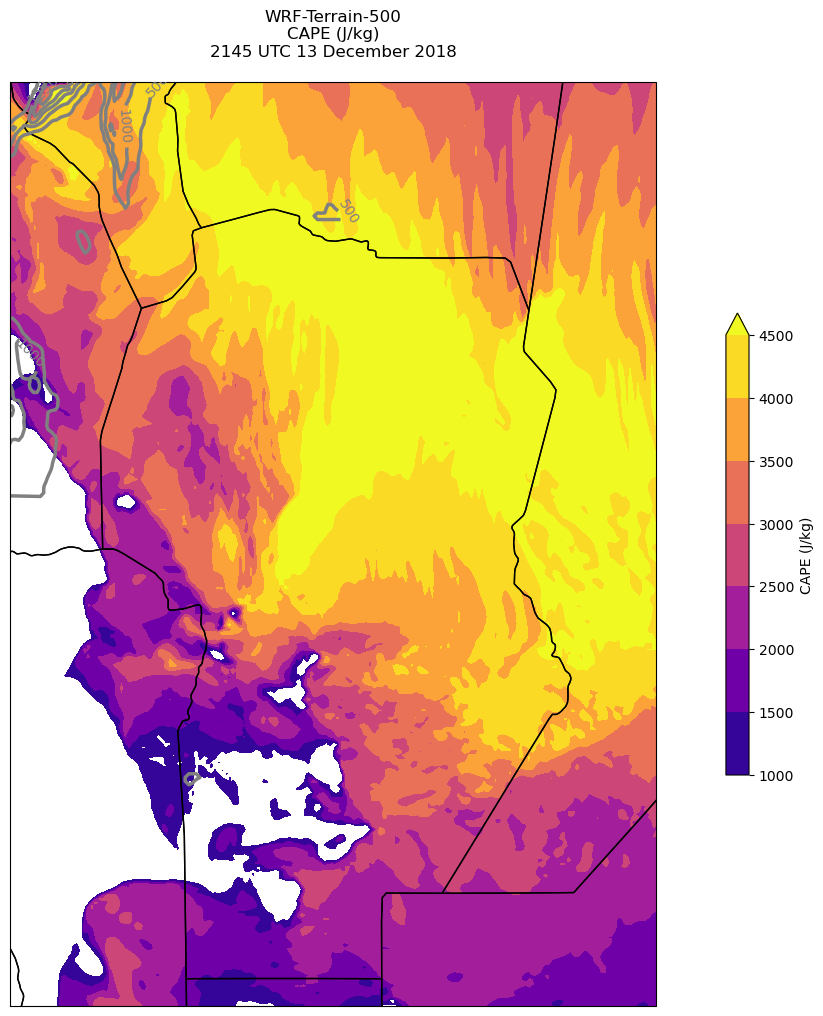

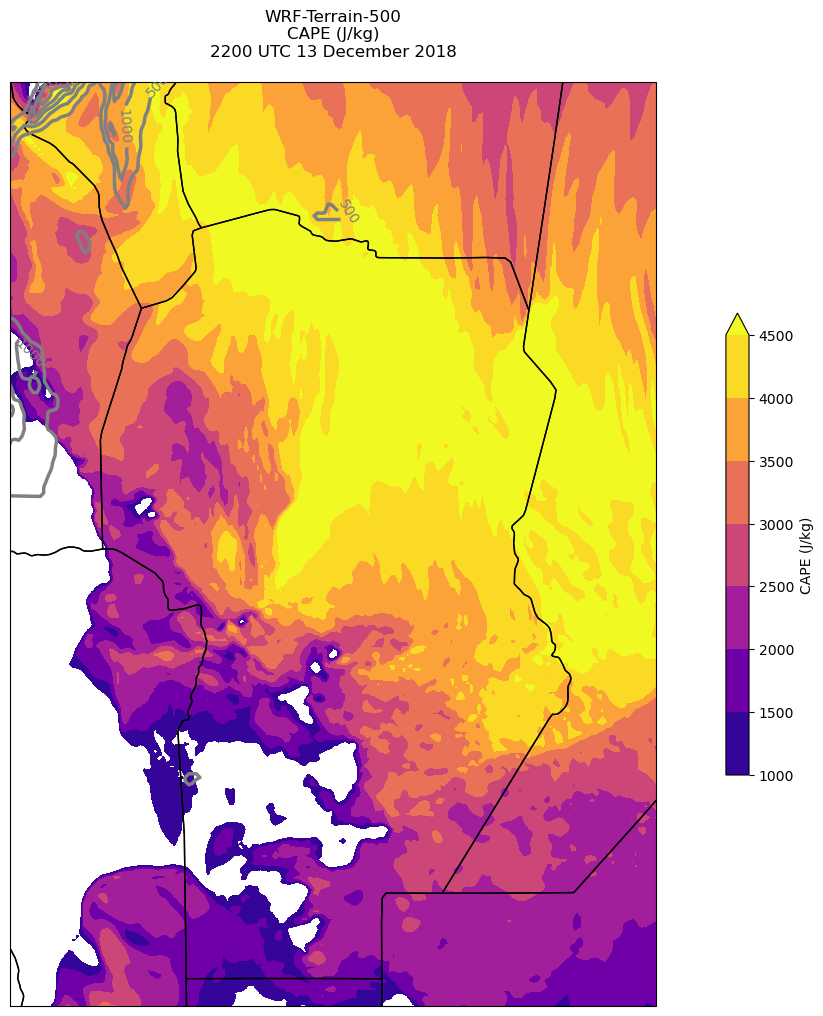

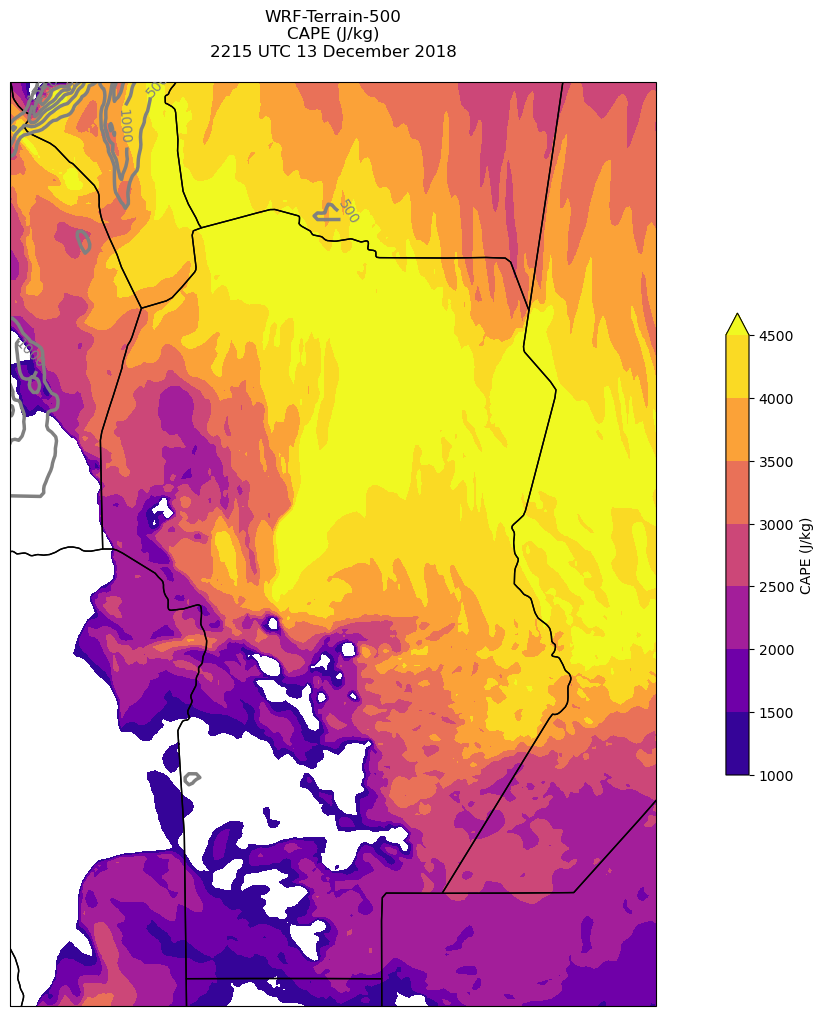

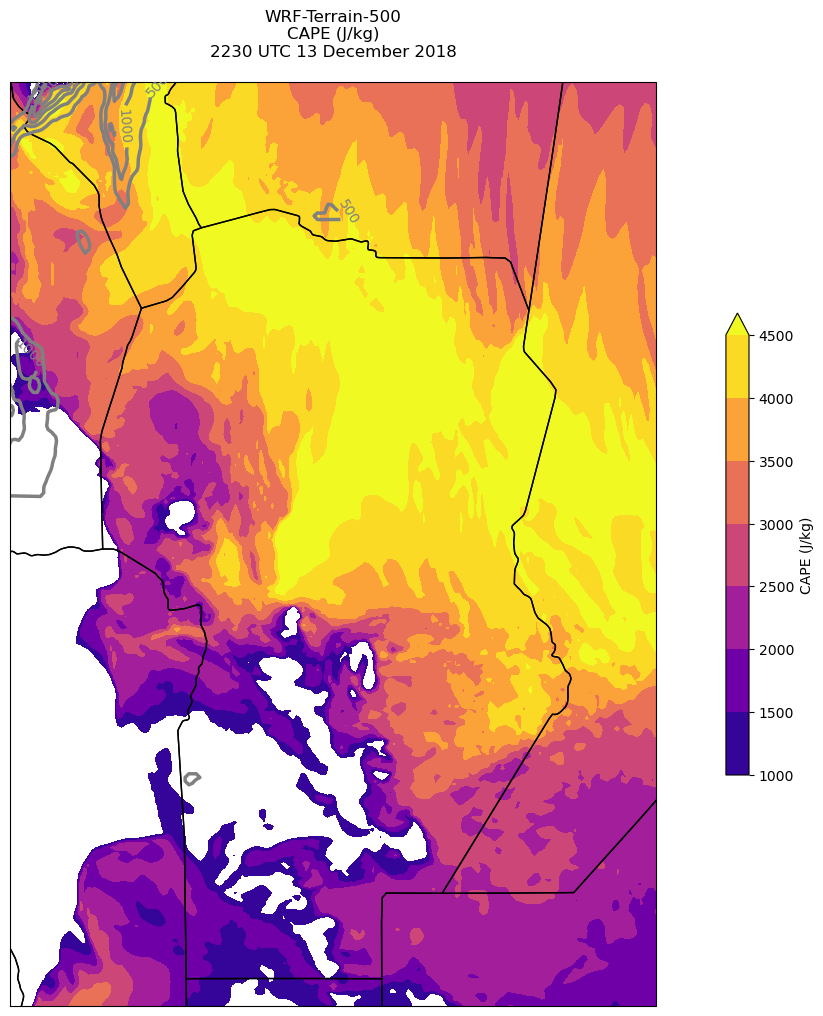

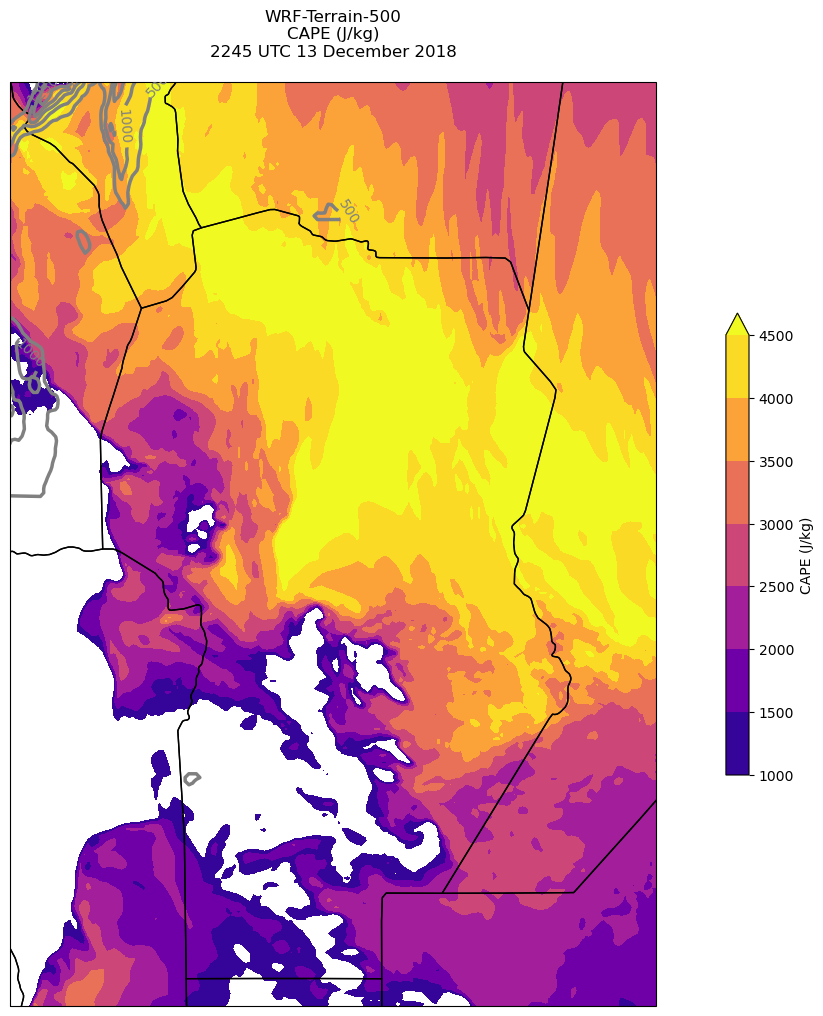

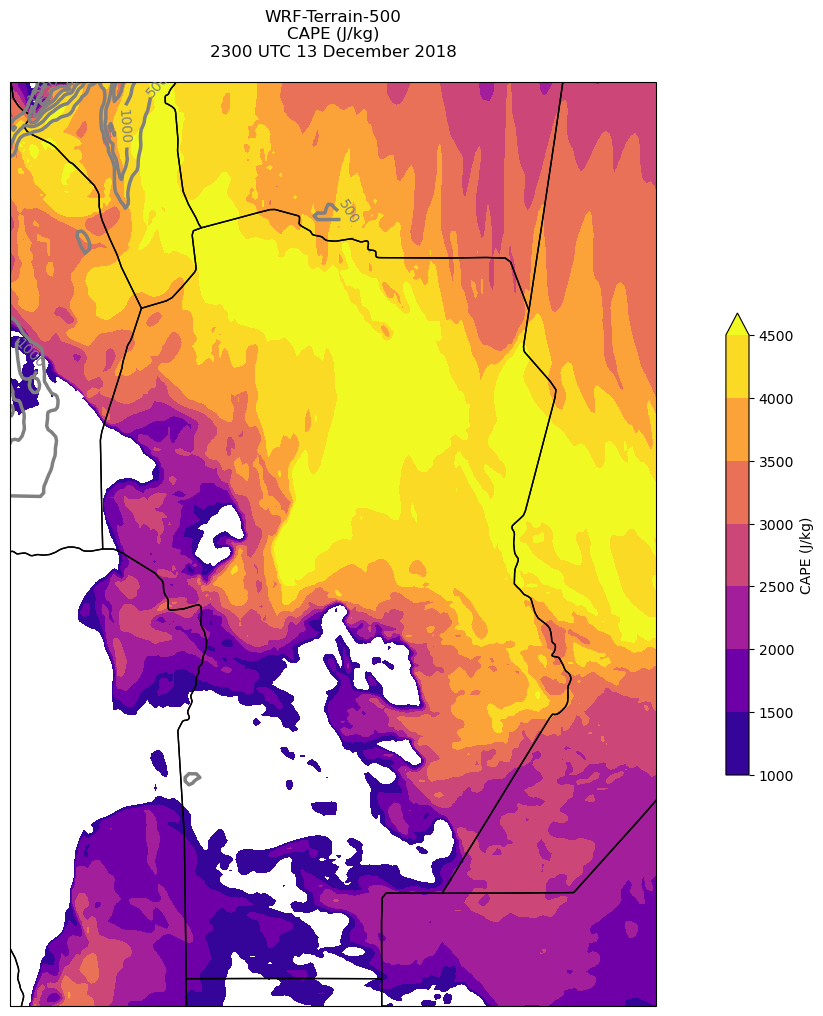

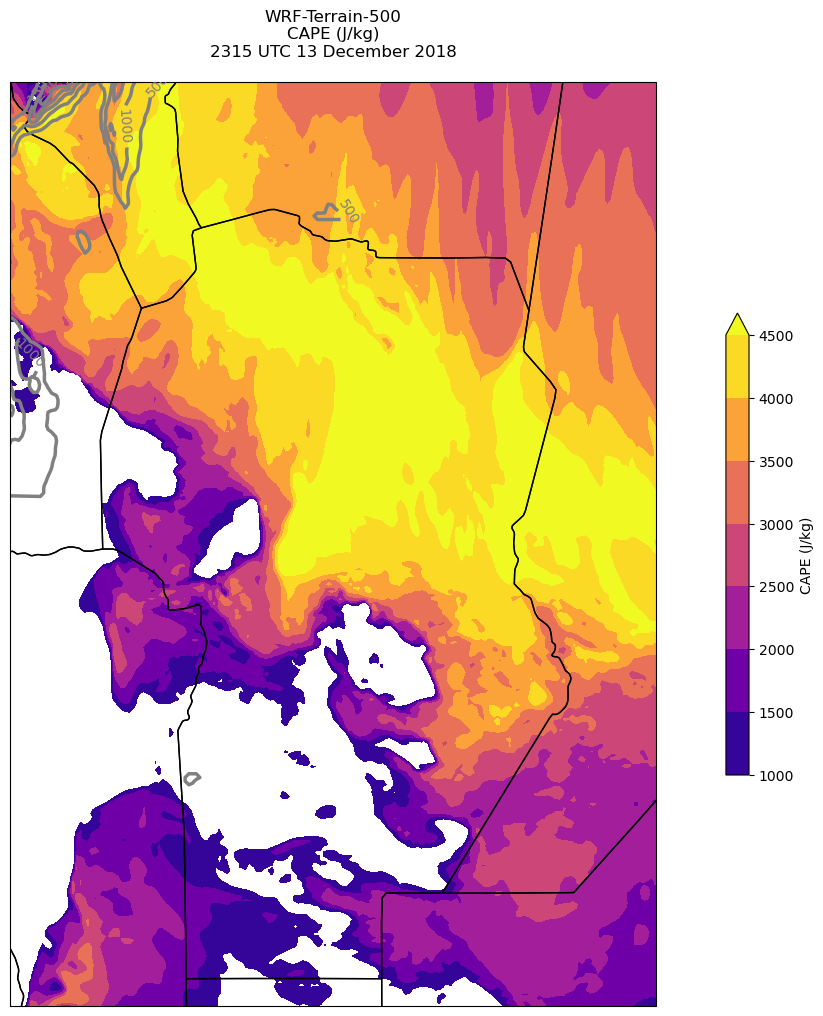

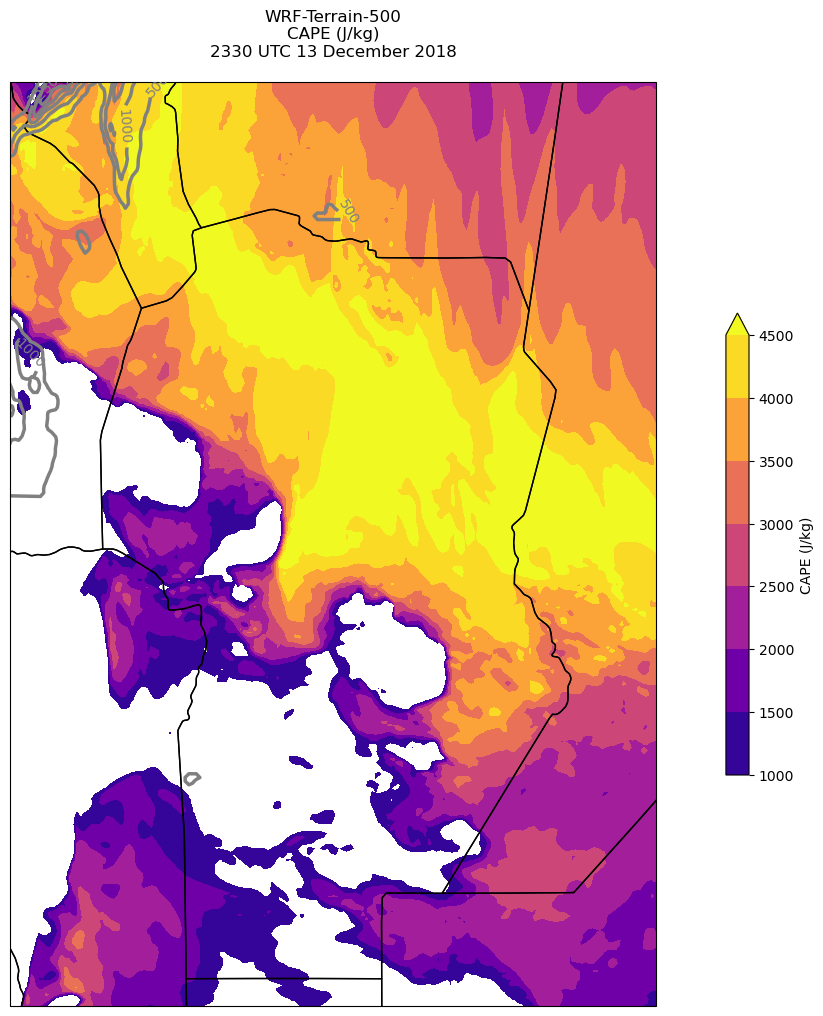

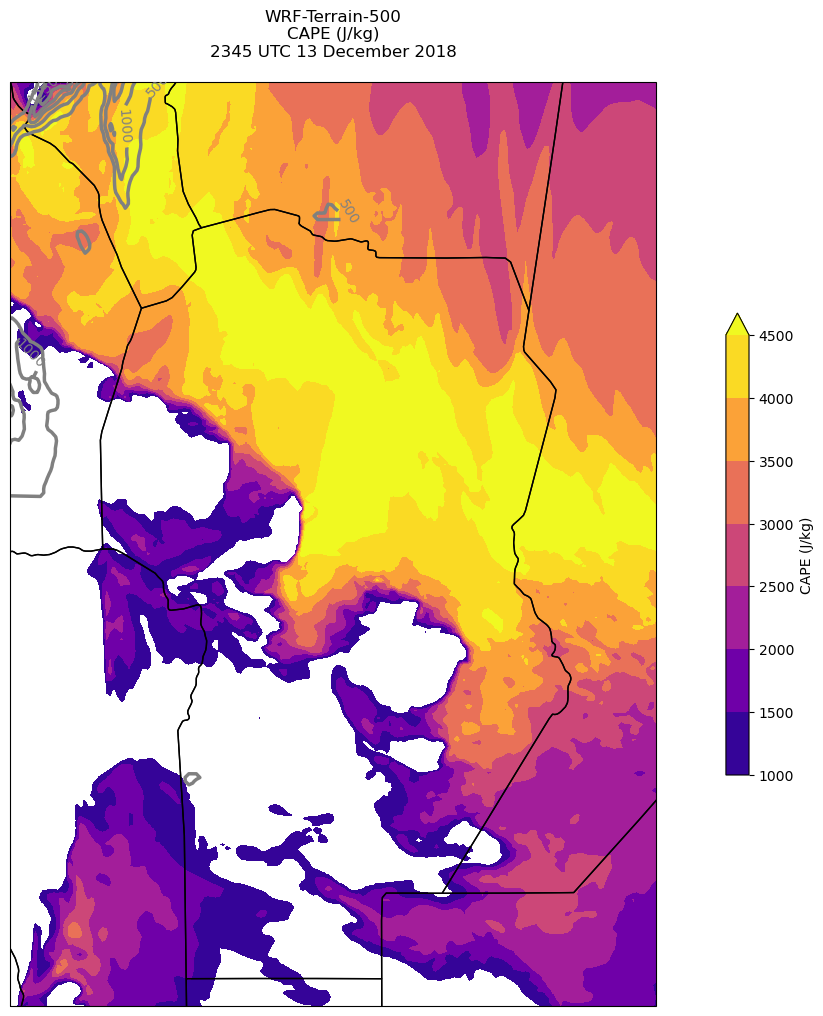

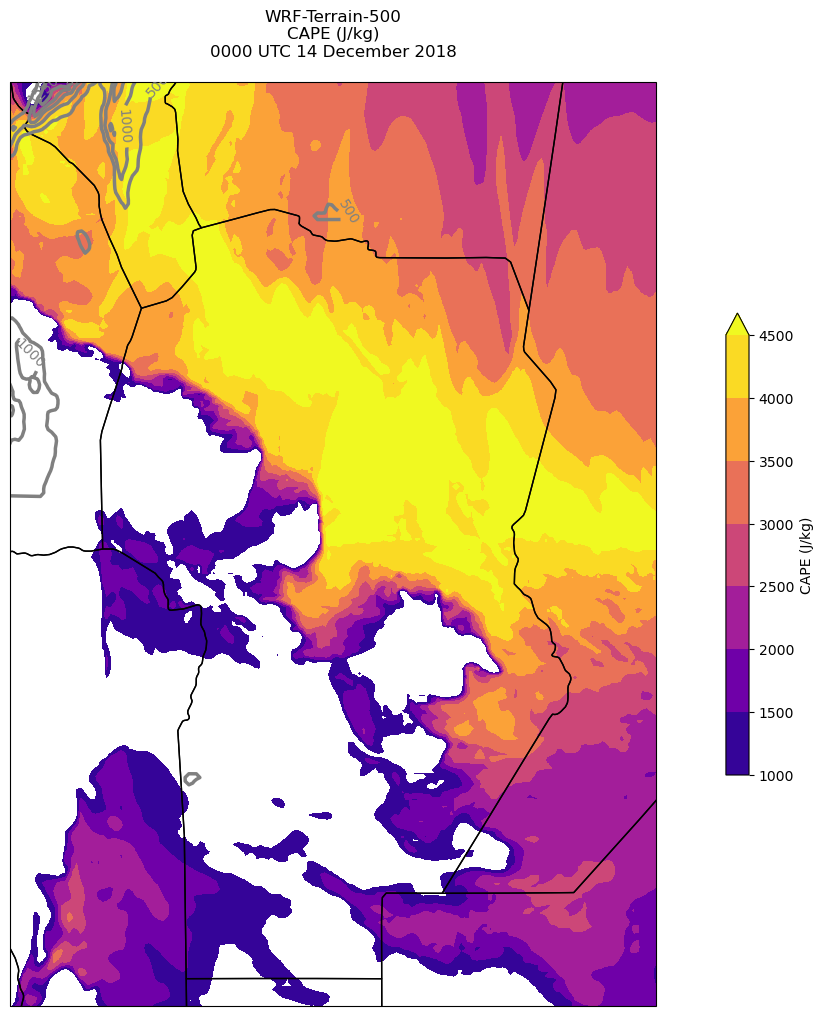

In [15]:
i=0
for value in time:
    fig = plt.figure(figsize=(18,12)) 
    ax = plt.subplot(1,1,1,projection=proj_map)
    ax.set_extent ([lonW+31,lonE-36,latS+24.8,latN-28.5])
    ax.add_feature(cf.COASTLINE.with_scale(res))
    ax.add_feature(cf.STATES.with_scale(res))
    
    CF = ax.contourf(lon, lat, cape.isel(Time=i), levels=capeLevs, cmap='plasma', extend='max', transform=proj_data)
    cbar = fig.colorbar(CF,shrink=0.5)
    cbar.set_label(r'CAPE (J/kg)', size='medium')
    
    CL = ax.contour(ter.XLONG, ter.XLAT, ter, levels=np.arange(500, 3000, 500), linewidths=2.5, colors='Grey', zorder=2, transform=proj_data)
    ax.clabel(CL)
    
    timeStr = dt.strftime(dateList[i], format='%H%M UTC %d %B %Y')
    
    tl1 = 'WRF-Terrain-500'
    tl2 = 'CAPE (J/kg)'
    tl3 = timeStr
    title_line = (tl1 + '\n' + tl2 + '\n' + tl3 + '\n')
    
    plt.title(title_line)
    
    i=i+1